# Introduction

In this tutorial, I will show you how you can code your own linear regression in Python. Unlike most tutorials, I also show you how to get standard errors, t and p-values, and confidence intervals for all estimated coefficients.

This tutorial not only shows you the implementation in Python, but also some of the mathematical background (i.e., formulas). I hope that, by seeing the combination of the two, you will gain a deeper understanding of how linear regression works. 

## A few notes beforehand

- My implementation is based on the OLS estimator, which uses matrix algebra to estimate regression coefficients, rather than maximum likelihood estimatiom (MLE) or Gradient Descent, which are iterative procedures.
- This approach requires that there are no missing values in the dataset.
- If you want to include categorical variables, these need to be converted into dummy variables first (and then you leave one out of the X matrix (see below)).
- I relied on [this guide](https://people.duke.edu/~hpgavin/SystemID/References/Jennings-LinearModels3-Purdue.pdf) for the math behind the model. Check it out, it is a really good overview.  

## Importing required packages

Let's start by importing the packages we need. We need pandas to read the data and to make pretty data frames. 

Numpy will be used for nifty calculations like transposing matrices. Lastly, we need the 'f' and 't' subfunctions from scipy.stats. These contain the F and t distribution, which we will be using later to obtain the p-values of the regression as a whole (based on the F distribution) and of the individual regression coefficients (based on the t distribution). 

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import f, t

## Loading the data

We will be using the Boston Housing dataset. I am lazy today, so I will not run any descriptive statistics. We load the data using pandas and examine the head. 

In [7]:
boston=pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


We see that we have 14 variables in the data set. We will be using 'medv' as the dependent variable and the rest as the independent variables for the purpose of this tutorial. 

Next, we separate the dependent variable (Y) from the independent variables (X).

In [8]:
X= boston.drop('medv', axis=1).values
Y= boston["medv"].values

We want to keep a list of the column names, which will form the index of the data frame that will hold our regression coefficients. First, we extract the column names from the boston dataset, then we insert the intercept of the regression at the first position, and delete the last column (which, remember, is the independent variable.

In [9]:
#Create list of column names
colnames = list(boston)
colnames.insert(0, 'Intercept')
del colnames[-1]
colnames

['Intercept',
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat']

Now we can create a dataframe that will hold the results of the regression and call it 'model'. As I just said, the colnames list will be used as the index. 

In [10]:
model = pd.DataFrame(index=colnames)
model.head()

""
Intercept
crim
zn
indus
chas


# Estimating the parameters!

## Estimating the betas

Our preparations are done, let's get started! 
First, we need to calculate two parameters that we will use often in the following: N and p. 
N is simply the number of observations in our dataset. So, in our case, 506. p is the number of variables that make up the regression (14).

In [11]:
N = len(X)
p = len(boston.columns)

First, we need to create a new dataframe that we call X_with_intercept with the shape (N,p). We fill up the first column with ones, this will be the intercept. The other columns will contain the values of the dataset, with exception of the values of the dependent variable (so all values from the "X" array we created.

In [12]:
X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = pd.DataFrame(X).values

Next, we will use matrix algebra to estimate the parameters, or 𝑏̂. This step is a bit complex ([See p. 4 here for a detailed explanation of how this works mathematically.](https://people.duke.edu/~hpgavin/SystemID/References/Jennings-LinearModels3-Purdue.pdf)). 

Basically, to get the bs, we need to multiply the matrix "X_with_intercept" with the vector containing the values of the dependent variable (Y) and multiply that with the inverse of the matrix we get from the multiplication of "X_with_intercept" with itself. Or, in math speak:

$$
    b = (X'X)^{-1} X'Y
$$

In Python, we use np.linalg.inv to get the inverse of the "X_with_intercept" matrix and multiply this with "X_with_intercept" again, and then with the values of "Y":

In [46]:
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ pd.DataFrame(Y).values
print(beta_hat)

[[ 3.64594884e+01]
 [-1.08011358e-01]
 [ 4.64204584e-02]
 [ 2.05586264e-02]
 [ 2.68673382e+00]
 [-1.77666112e+01]
 [ 3.80986521e+00]
 [ 6.92224640e-04]
 [-1.47556685e+00]
 [ 3.06049479e-01]
 [-1.23345939e-02]
 [-9.52747232e-01]
 [ 9.31168327e-03]
 [-5.24758378e-01]]


Next, we assign the betas to a new column, 'B', of the model dataframe. Let's take a look!

In [14]:
model['B']=beta_hat

In [15]:
model

,B
Intercept,36.459488
crim,-0.108011
zn,0.046420
indus,0.020559
chas,2.686734
nox,-17.766611
rm,3.809865
age,0.000692
dis,-1.475567
rad,0.306049


We extract the intercept into one list ("intercept") and all other coefficients into another list ("other_betas").

In [38]:
intercept = beta_hat[0]
other_betas = beta_hat[1:]

Next, we need to calculate the predicted values. They are not terribly interesting by themselves, but they are needed to calculate other parameters, such as the standard errors.

The predicted values are commonly called "y hat", based on their mathematical symbol ŷ (get it, it looks like a y wearing a hat). ŷ is simply the value of the dependent variable (the y) that our model predicts based on the intercept and slope coefficients.

ŷ is calculated by, for every observation, multiplying the regression coefficients with the values on the respective variables for every observation, and then adding the intercept to that. In matrix notation, ŷ is the cross product of the regression coefficients vector and the matrix X, plus the intercept.

We implement this by using np.dot, which multiplies matrices. 

In [18]:
y_hat = intercept + np.dot(X, other_betas)

## Calculating standard errors

Calculating the standard errors is a bit more tedious. The standard errors are the cross product of the MSE 

$$
    se=MSE × (X'X)
$$

The MSE, or mean squared error, is the sum of squares of all errors, divided by the degrees of freedom of the error. Put more simply, we calculate the SSE by, for each row in the dataset, taking the actual value of Y, substract the predicted value from it, and squaring the result. Then, we add up all of these individual sums of squares and divide the resulting number by the number of the rows, minus the number of predictors of the model.

$$
    MSE= \frac{SSE}{df_{e}} =  \frac{(\sum \hat y _{i} - \bar y _{i})^2}{n-p}
$$



How do we implement this? First, for sake of convenience, we put the actual values of Y and the values for Y our model predicted in one dataframe and print the shape. 

In [44]:
Ys=pd.DataFrame()
Ys["Yactual"]=Y
Ys["Ypred"]=y_hat
Ys.head()

,Yactual,Ypred
0,24.0,30.003843
1,21.6,25.025562
2,34.7,30.567597
3,33.4,28.607036
4,36.2,27.943524


Next, we can easily calulate the MSE by using np.square to square the differences between the actual and the predicted values of Y, and np.sum to sum up the result. We divide the result by N-p (we defined these parameters above, remember?)

In [45]:
mse=(np.sum(np.square(Ys["Yactual"]-Ys["Ypred"])))/(N-p)
mse

22.517854833241827

We almost have our standard errors! The next step is to calculate the covariance matrix. The covariance matrix gives the covariance between each pair of parameters we estimated from the model (so including the intercept). Along the diagonal is the variance of the individual parameters, and if we take the square root of the variance we get the standard errors!

To implement this, we first estimate the covariance matrix by multiplying each element of the XX matrix with the MSE, and then looping over the square root of the diagonal (which we get with np.diag). We store the result in the array "standarderrors", which we append to our "model" dataframe in the "SE" column.

In [21]:
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * mse 

In [22]:
for p_ in range(len(model)):
    standarderrors = np.diag(var_beta_hat)**0.5

In [23]:
standarderrors

array([5.10345881e+00, 3.28649942e-02, 1.37274615e-02, 6.14956890e-02,
       8.61579756e-01, 3.81974371e+00, 4.17925254e-01, 1.32097820e-02,
       1.99454735e-01, 6.63464403e-02, 3.76053645e-03, 1.30826756e-01,
       2.68596494e-03, 5.07152782e-02])

In [24]:
model["SE"]=standarderrors
model

,B,SE
Intercept,36.459488,5.103459
crim,-0.108011,0.032865
zn,0.046420,0.013727
indus,0.020559,0.061496
chas,2.686734,0.861580
nox,-17.766611,3.819744
rm,3.809865,0.417925
age,0.000692,0.013210
dis,-1.475567,0.199455
rad,0.306049,0.066346


## Calculating the t values

T values are not super interesting by themselves, but we need them to calculate the p-values of the regression parameter estimates (the bs). Calculating the t-values is super easy now: t is simply the regression coefficient divided by its standard error. We can simply divide the two columns of the data frame and assign the result to a new column, t.


$$
    t=\frac{b}{se}
$$

In [25]:
model['t']=model["B"]/model["SE"]
model

,B,SE,t
Intercept,36.459488,5.103459,7.144074
crim,-0.108011,0.032865,-3.286517
zn,0.046420,0.013727,3.381576
indus,0.020559,0.061496,0.334310
chas,2.686734,0.861580,3.118381
nox,-17.766611,3.819744,-4.651257
rm,3.809865,0.417925,9.116140
age,0.000692,0.013210,0.052402
dis,-1.475567,0.199455,-7.398004
rad,0.306049,0.066346,4.612900


## Calculating p-values

Based on the t value, we can get the p-value of the regression coefficients. 

This next step requires a bit more explanation. 



We will use the t.sf function, which contains all values of the t-distribution. 

In [26]:
p_values=np.around((t.sf(np.abs(model['t']), N-1)*2), 3)
model['p']=p_values
model

,B,SE,t,p
Intercept,36.459488,5.103459,7.144074,0.000
crim,-0.108011,0.032865,-3.286517,0.001
zn,0.046420,0.013727,3.381576,0.001
indus,0.020559,0.061496,0.334310,0.738
chas,2.686734,0.861580,3.118381,0.002
nox,-17.766611,3.819744,-4.651257,0.000
rm,3.809865,0.417925,9.116140,0.000
age,0.000692,0.013210,0.052402,0.958
dis,-1.475567,0.199455,-7.398004,0.000
rad,0.306049,0.066346,4.612900,0.000


## Calculating 95% confidence intervals

We can easily calculate the 95% confidence intervals from the regression coefficients and their corresponding standard errors.

Recall that the formula for the confidence intervals is as follows:

$$
    CI = B ± 1.96 * SE
$$

So, we can simply take the values of the SE column, multiply them by 1.96 and add (upper 95% CI) or subtract (lower 95% CI) them to/from the values in the B column. Easy peasy!

In [43]:
model['ci_lower']=model["B"]-1.96*model["SE"]
model['ci_upper']=model["B"]+1.96*model["SE"]
model

,B,SE,t,p,ci_lower,ci_upper
Intercept,36.459488,5.103459,7.144074,0.000,26.456709,46.462268
crim,-0.108011,0.032865,-3.286517,0.001,-0.172427,-0.043596
zn,0.046420,0.013727,3.381576,0.001,0.019515,0.073326
indus,0.020559,0.061496,0.334310,0.738,-0.099973,0.141090
chas,2.686734,0.861580,3.118381,0.002,0.998037,4.375430
nox,-17.766611,3.819744,-4.651257,0.000,-25.253309,-10.279914
rm,3.809865,0.417925,9.116140,0.000,2.990732,4.628999
age,0.000692,0.013210,0.052402,0.958,-0.025199,0.026583
dis,-1.475567,0.199455,-7.398004,0.000,-1.866498,-1.084636
rad,0.306049,0.066346,4.612900,0.000,0.176010,0.436089


# Calculating Model Fit Statistics

Our regression table is done, but we are still lacking some global information on our model. For example, how well does the model fit (i.e., does it explain much or little of the variance in the dependent variable)?

To answer such questions, we will calculate some basic model fit statistics: the R squared, the adjusted R squared, the root mean squared error (RMSE) and the F-value together with its corresponding p-value.

To start off, we initialize an empty data frame and call it "modelfit".

In [28]:
modelfit=pd.DataFrame()

## Calculating R squared

Let us first calculate R squared, also known as the "coefficient of determination" or "coefficient of multiple correlation". R squared indicates the proportion of the variance that is explained by our model, ranging from 0 (no variance explained at all, our model is crap) to 1 (all variance explained, our model is perfect). 

The formula for R squared is as follows:

$$
    R^2 = 1- \frac{RSS}{SST}
$$ 

RSS (sum of squares of residuals) and SST (sum of squares total) are, in turn, calculated as follows:

$$
    RSS = \sum (Y_{i} - \hat y_{i})^2
$$

$$
    SST = \sum (Y_{i} - \bar Y) ^2
$$

The implementation in Python is straightforward: We calculate the RSS by using np.sum to summarize the square of the difference between the "Yactual" and "Ypred" columns of our Ys dataframe. To calculate the SST, we first calculate the mean of the "Yactual" column, before using np.sum to sum up the squares of the differences between the actual values of Y ("Yactual") and the mean of Y ("mean"). 

R squared is then, simply 1 minus RSS divided by SST!

In [29]:
#R squared
rss=np.sum(np.square((Ys["Yactual"]-Ys["Ypred"])))
#Calculate the mean of Y
mean=np.mean(Ys["Yactual"])
#Calculate the sum of squares total: sum of the squared differences between Y and the mean of Y
sst = np.sum(np.square(Ys["Yactual"]-mean))
#Calculate the r_squared: 1 minus rss/sst
r_squared = 1 - (rss/sst)

## Calculating the Adjusted R squared

Sometimes it is useful to also look at the adjusted R squared. Adjusted R2 is simply R2, but adjusted for the number of terms (predictors and observations) in the model. 

We calculate the adjusted R squared by: 

$$
    Adjusted R^2 = 1 - \frac{(1-R^2)(N-1)}{N-p-1}
$$

This can be written in one easy line in Python:

In [30]:
#Adjusted r squared
r_sq_adj = 1- ((1-r_squared)*((N-1)/(N-p-1)))

## Calculating the Root Mean Square Error (RMSE)

The RMSE is the standard deviation of the residuals. In other words, the RMSE tells us how far the residuals are spread out from the regression line. A value of 0 indicates that the data fit the line perfectly. In general, the smaller the RMSE, the better.

As the name already suggests, the RMSE is the square root of the MSE which we calculated above! 


$$
    RMSE = \sqrt {MSE}
$$

Just like the Adjusted R squared, the RMSE is a one liner:

In [31]:
#Root MSE
rmse=mse**0.5

## Calculating the F value and its corresponding p-value

The F-test indicates whether our regression model provides a better fit than a model that contains no independent variables at all. If the F-test turns out statistically significant (i.e., it's p-value is below some arbitrary treshold, usually 0.05), we conclude that our model as a whole predicts Y to some extent.

The F value is simply:

$$ 
    F = \frac{MSM}{MSE}
$$

The MSE we have already calculated, but the MSM is new. The MSM is simply the sum of the squares of the differences between the predicted values for Y (ŷ) and the actual values of Y:

$$
    MSM = \sum (\hat Y_{i}- \bar Y)^2
$$

So, to calculate the MSM, we again use np.square and np.sum, and then divide msm by mse to get the F value.

In [34]:
msm=(np.sum(np.square(Ys["Ypred"]-mean)))/(p-1)
fval=msm/mse

How do we get the p-value for the F-test? Well, we have to look up the F value in the table of the F distribution or, simply, use the function f.sf, which gives the p-values for any give F value. The function takes three arguments: the f-value we calculated, and the degrees of freedom of the model (p-1) and of the residuals (n-p). I wrapped this function in np.around to round the p-values to three decimals:

In [35]:
p_off = np.around(f.sf(fval, (p-1), (N-p)), 3)

Now we can create a dataframe that holds our essential model fit statistics: the number of observations, N, the R squared and Adjusted R squared, the RMSE, the F-value and the p-value of the F-value. I make two lists, one holding the values themselves, and another one holding their labels/names, and use pd.DataFrame to combine them into a dataframe called "modelinfo".

In [36]:
modelfitvals=[N, r_squared, r_sq_adj, rmse, fval, p_off]
colnames_modelfit=["Number of observations", "R sq", "Adjusted R sq", "Root MSE", "F", "Prob>F"]
modelinfo = pd.DataFrame(modelfitvals, index=colnames_modelfit)

,0
Number of observations,506.000000
R sq,0.740643
Adjusted R sq,0.733248
Root MSE,4.745298
F,108.076666
Prob>F,0.000000


# The Result!

Let's print the model fit statistics and the final model:

In [41]:
modelinfo

,0
Number of observations,506.000000
R sq,0.740643
Adjusted R sq,0.733248
Root MSE,4.745298
F,108.076666
Prob>F,0.000000


In [42]:
model

,B,SE,t,p,ci_lower,ci_upper
Intercept,36.459488,5.103459,7.144074,0.000,26.456709,46.462268
crim,-0.108011,0.032865,-3.286517,0.001,-0.172427,-0.043596
zn,0.046420,0.013727,3.381576,0.001,0.019515,0.073326
indus,0.020559,0.061496,0.334310,0.738,-0.099973,0.141090
chas,2.686734,0.861580,3.118381,0.002,0.998037,4.375430
nox,-17.766611,3.819744,-4.651257,0.000,-25.253309,-10.279914
rm,3.809865,0.417925,9.116140,0.000,2.990732,4.628999
age,0.000692,0.013210,0.052402,0.958,-0.025199,0.026583
dis,-1.475567,0.199455,-7.398004,0.000,-1.866498,-1.084636
rad,0.306049,0.066346,4.612900,0.000,0.176010,0.436089


Let us now compare this result to the ones obtained from Stata. In Stata, we would type

import delimited https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv

to import the file and 

reg medv crim zn indus chas nox rm age dis rad tax ptratio b lstat

to run the regression. These are the results from Stata:

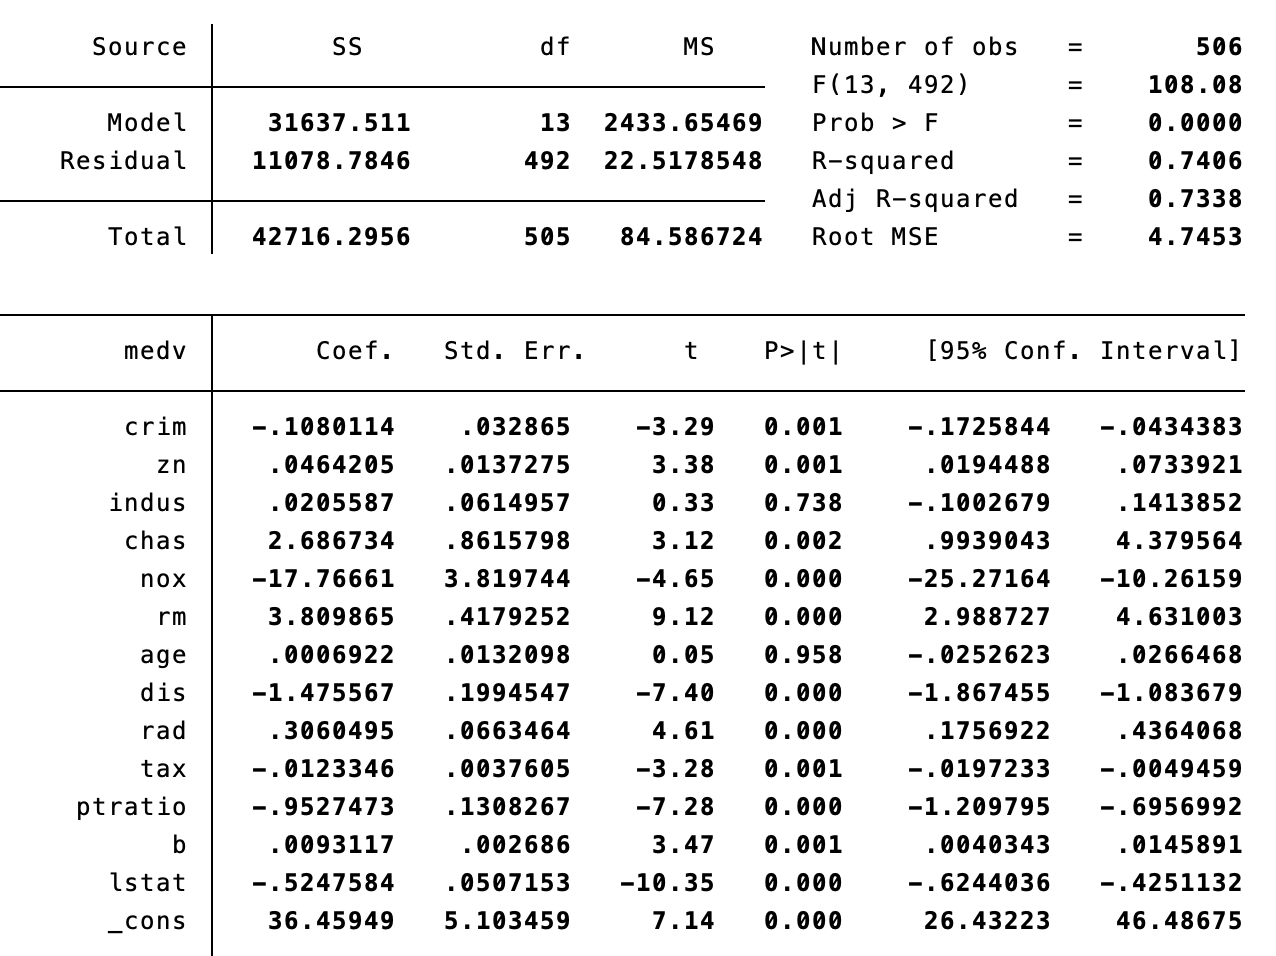


Note that Stata indicates the intercept with "_cons".

If we compare our coefficients with the ones from Stata we can see that they are the same. Neat! 

So there you have it: OLS regression in Python!